In [1]:
import sys

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
import torch.nn.functional as F
from intvalpy import lineqs

import cvxpy as cp

import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from intvalpy import lineqs3D

import time

import pickle


import multiprocessing
from multiprocessing import Pool

import pandas as pd


In [2]:
from functions import get_polytope_list
from functions import bit_vector_from_relus
from functions import get_inequalities

#multiprocessing
from functions import active_bits_index

#non-multiprocessing
from functions import active_bits_index_2
from functions import clip_vertices
from functions import calculate_center_of_mass

# NN class

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden_sizes = hidden_sizes


        # Create layers dynamically based on the hidden_sizes list
        for i in range(len(hidden_sizes)):
            layer_name = f"l{i+1}"
            relu_name = f"relu{i+1}"
            if i == 0:
                
                setattr(self, layer_name, nn.Linear(input_size, hidden_sizes[i]))
                setattr(self, relu_name, nn.ReLU())
            else:
                setattr(self, layer_name, nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                setattr(self, relu_name, nn.ReLU())
                
        output_layer_name = f"l{len(hidden_sizes)+1}"

        setattr(self, output_layer_name, nn.Linear(hidden_sizes[-1], num_classes))

    def forward(self, x):
        out = x
        for i in range(len(self.hidden_sizes)):
            layer_name = f"l{i+1}"
            relu_name = f"relu{i+1}"
            out = getattr(self, layer_name)(out)
            out = getattr(self, relu_name)(out)

        output_layer_name = f"l{len(self.hidden_sizes)+1}"
        out = getattr(self, output_layer_name)(out)
        return out



In [4]:
model = NeuralNet(input_size=28*28, num_classes=10, hidden_sizes=[340, 340, 340, 340, 340])

model.load_state_dict(torch.load("example_models/demo_mnist_5h_340n.pth"))
model.eval()

NeuralNet(
  (l1): Linear(in_features=784, out_features=340, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=340, out_features=340, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=340, out_features=340, bias=True)
  (relu3): ReLU()
  (l4): Linear(in_features=340, out_features=340, bias=True)
  (relu4): ReLU()
  (l5): Linear(in_features=340, out_features=340, bias=True)
  (relu5): ReLU()
  (l6): Linear(in_features=340, out_features=10, bias=True)
)

torch.Size([100, 1, 28, 28]) torch.Size([100])
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


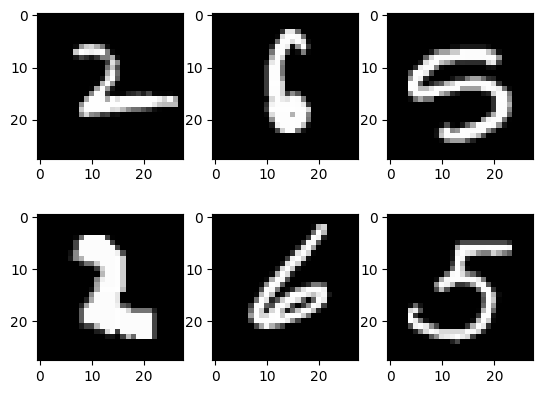

In [5]:
batch_size = 100
# MNIST
train_dataset = torchvision.datasets.MNIST(root="./data", train=True,
                                           transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False,
                                           transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,
                                           shuffle=True,)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,
                                           shuffle=False)
examples = iter(train_loader)
samples, label = next(examples)
print(samples.shape,label.shape)
print(train_dataset,test_dataset )

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')

In [6]:
train_set_array = np.transpose(train_dataset.data.numpy().reshape(-1,28*28))
test_set_array = np.transpose(test_dataset.data.numpy().reshape(-1,28*28))
train_set_array_targets = train_dataset.targets.numpy()


train_set_array.shape, test_set_array.shape, train_set_array_targets.shape

((784, 60000), (784, 10000), (60000,))

In [7]:
train_images = np.transpose(train_set_array)
test_images = np.transpose(test_set_array)

train_images.shape, test_images.shape

((60000, 784), (10000, 784))

# 1. Task: Bit Vector

- Task: Calculate the bit vector of a given data point using a pretrained ReLU feedforward neural network.

- Demonstration: Take a data point from the MNIST dataset, compute its bit vector, and display the resul

Random No:  32606


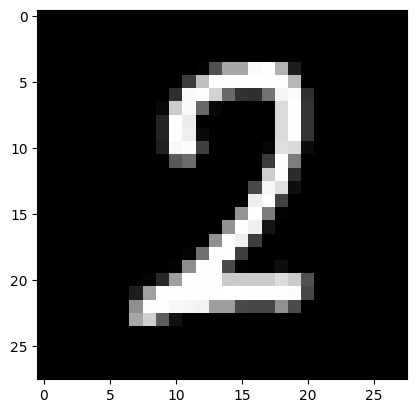

In [8]:
random.seed(50)
random_number = random.randint(0, train_set_array.shape[1]-1)
print("Random No: ",random_number )

random_sample = np.transpose(train_set_array[:,random_number]).reshape(-1,1)
plt.imshow(random_sample.reshape(28,28), cmap='gray')
plt.show()


In [9]:
bit_vector_of_an_image  = bit_vector_from_relus(model, random_sample, stack_layers = True, verbose=False, get_unique_bit_vectors_only=False)

In [10]:
print("Shape of the bit vector: ")
bit_vector_of_an_image[0].shape

Shape of the bit vector: 


(1700, 1)

In [11]:
bit_vector_of_an_image_no_stack  = bit_vector_from_relus(model, random_sample, stack_layers = False, verbose=False, get_unique_bit_vectors_only=False)

In [12]:
counter = 1
for a_bit_vector in bit_vector_of_an_image_no_stack[0]:
    print(f"Shape of the {counter}. hidden layer's bit vector: {a_bit_vector.shape}")
    counter += 1
    
    

Shape of the 1. hidden layer's bit vector: (340, 1)
Shape of the 2. hidden layer's bit vector: (340, 1)
Shape of the 3. hidden layer's bit vector: (340, 1)
Shape of the 4. hidden layer's bit vector: (340, 1)
Shape of the 5. hidden layer's bit vector: (340, 1)


In [13]:
bit_vector_of_an_image_no_stack

[[array([[1],
         [0],
         [0],
         [0],
         [1],
         [1],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [1],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [1],
         [1],
         [1],
         [1],
         [0],
         [1],
         [0],
         [1],
         [0],
         [1],
         [0],
         [1],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [1],
         [0],
         [0],
         [1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
      

# 2. Task: Linear Model for a Polyhedron

- Task: Derive the linear model corresponding to a polyhedron based on a given data point.

- Demonstration: Given a data point from the MNIST dataset, we aim to derive its linear model, represented by Ax <= c. The matrix A and vector c will be expressed in terms of the bit vector, weight matrix, and bias. We will provide the sizes of matrix A, vector c, and the bit vector itself to enhance clarity and understanding.

Random No:  32606


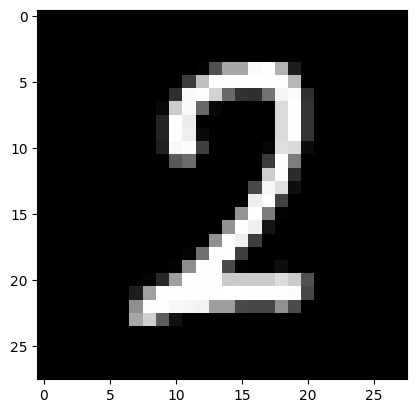

In [14]:
random.seed(50)
random_number = random.randint(0, train_set_array.shape[1]-1)
print("Random No: ",random_number )

random_sample = np.transpose(train_set_array[:,random_number]).reshape(-1,1)
plt.imshow(random_sample.reshape(28,28), cmap='gray')
plt.show()

In [15]:
A_random_sample, c_random_sample = get_inequalities(model,random_sample,return_bit_vec_list=False )

In [16]:
#Linear model: Ax <= c.
print("Shape of A: ", A_random_sample[0].shape)
print("Shape of c: ", c_random_sample[0].shape)

Shape of A:  (1700, 784)
Shape of c:  (1700, 1)


In [17]:
A_random_sample

[array([[ 1.11242114e-02, -1.34143112e-02, -7.52371596e-03, ...,
          6.89999154e-03,  2.38388702e-02, -2.94804238e-02],
        [ 1.08416639e-02, -2.98566781e-02, -2.41797455e-02, ...,
          1.53988907e-02, -3.23618911e-02,  1.40620219e-02],
        [-3.40046221e-03, -7.44040962e-03,  3.08615323e-02, ...,
          2.31620502e-02, -2.77973674e-02,  2.70181652e-02],
        ...,
        [ 5.95307726e-03,  6.49969747e-03, -5.50288752e-03, ...,
          5.75752625e-03,  1.03185882e-02,  1.64407311e-02],
        [ 5.93417704e-03, -7.19756087e-04, -3.26028518e-03, ...,
          9.34544932e-06, -8.37722054e-03,  5.95132135e-03],
        [ 3.09792607e-03, -1.09241643e-03, -2.35405553e-02, ...,
         -4.90398601e-03, -5.78189101e-03,  2.06134137e-02]])]

In [18]:
c_random_sample

[array([[-0.00437213],
        [ 0.04443258],
        [-0.01637799],
        ...,
        [-0.06316076],
        [-0.01189788],
        [ 0.07626329]])]

# 3. Task Minimum Set of the Linear Model (Active Bits of the Bit Vector):

- Task: Determine the minimum set of linear inequalities that are necessary to define a given polyhedron and identify the active bits in the corresponding bit vector.

- Demonstration 1: Showcase the minimum number of required linear inequalities and present the active bit vector.

- Demonstration 2: Assess the computational scalability of the approach by analyzing the computational complexity of determining all active bits and plotting the runtime versus the number of nodes in the MNIST dataset.

In [19]:
model_8_nodes = NeuralNet(input_size=2, num_classes=1, hidden_sizes=[4, 4])
model_8_nodes.load_state_dict(torch.load("example_models/demo_8_nodes.pth"))
model_8_nodes.eval()


n = 100
x_1 = np.linspace(-1, 1, n, dtype="float32")
x_2 = np.linspace(-1, 1, n, dtype="float32")
x_1, x_2 = np.meshgrid(x_1, x_2)
x_1 = np.reshape(x_1, (n**2,1))
x_2 = np.reshape(x_2, (n**2,1))

y_train = np.asarray([i**2+j**2-2/3 for i, j in zip(x_1, x_2)])
x_train = np.concatenate((x_1,x_2), axis = 1)

# print(y_train.shape, x_train.shape)

# x_train_tp = np.transpose(x_train)

random.seed(8)
random_number = random.randint(0, x_train.shape[0]-1)

random_sample = np.transpose(x_train[random_number,:]).reshape(-1,1)
print("Random sample shape: ",random_sample.shape)

Random sample shape:  (2, 1)


In [20]:
A_random_sample, c_random_sample = get_inequalities(model_8_nodes,random_sample,return_bit_vec_list=False )
        
indexes_for_active_bits_random_sample = active_bits_index (A_random_sample,c_random_sample, verbose=False, n_jobs=2)

In [21]:
print("Active bit index list for random sample's bit vector: ")
indexes_for_active_bits_random_sample

Active bit index list for random sample's bit vector: 


array([3, 4, 6, 7])

# Task 4. Traversal of Neighbors of a Polyhedron:

- Task: Given a data point, identify the linear model of the polyhedron it belongs to, use the method from task 3 to find the active bits, and flip them to determine all neighboring polyhedra.

In [22]:
random.seed(8)
random_number = random.randint(0, x_train.shape[0]-1)

random_sample = np.transpose(x_train[random_number,:]).reshape(-1,1)
print("Random sample:\n ", random_sample)
print("Random sample shape: ",random_sample.shape)

Random sample:
  [[-0.7171717 ]
 [-0.25252524]]
Random sample shape:  (2, 1)


In [23]:
# def get_inequalities(model, test, is_input_sample=True, verbose=False, return_bit_vec_list=True, input_dimension=None ):

A_random_sample, c_random_sample, random_sample_bit_vector_list = get_inequalities(model_8_nodes,random_sample,return_bit_vec_list=True, input_dimension =2 )
        
indexes_for_active_bits_random_sample = active_bits_index (A_random_sample,c_random_sample, verbose=False, n_jobs=2)

# random_sample_bit_vector_list = bit_vector_from_relus(model, random_sample.reshape(-1,1))

polyhedra_list, active_bit_count_list  = get_polytope_list(random_sample_bit_vector_list[0], indexes_for_active_bits_random_sample, model=model_8_nodes)

In [24]:
print("# of polyhedra:" ,len(polyhedra_list))

# of polyhedra: 30


In [25]:
t = [np.array_split(a_poly, 2) for a_poly in polyhedra_list]

In [26]:
t

[[array([[1],
         [0],
         [1],
         [0]]),
  array([[0],
         [0],
         [1],
         [1]])],
 [array([[1],
         [0],
         [1],
         [1]]),
  array([[0],
         [0],
         [1],
         [1]])],
 [array([[1],
         [0],
         [1],
         [0]]),
  array([[1],
         [0],
         [1],
         [1]])],
 [array([[1],
         [0],
         [1],
         [0]]),
  array([[0],
         [0],
         [0],
         [1]])],
 [array([[1],
         [0],
         [1],
         [0]]),
  array([[0],
         [0],
         [1],
         [0]])],
 [array([[0],
         [0],
         [1],
         [1]]),
  array([[0],
         [0],
         [1],
         [1]])],
 [array([[1],
         [0],
         [1],
         [1]]),
  array([[1],
         [0],
         [1],
         [1]])],
 [array([[1],
         [0],
         [1],
         [1]]),
  array([[0],
         [0],
         [0],
         [1]])],
 [array([[1],
         [0],
         [0],
         [0]]),
  arra

In [27]:
print("List of polyhedra:\n ",polyhedra_list )

List of polyhedra:
  [array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1]]), array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1]]), array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1]]), array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1]]), array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0]]), array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1]]), array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]]), array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1]]), array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]]), array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [28]:
counter = 1
for a_polyhedra in polyhedra_list:
    print(f"Shape of {counter}. polyhedra: ",a_polyhedra.shape )
    counter += 1

Shape of 1. polyhedra:  (8, 1)
Shape of 2. polyhedra:  (8, 1)
Shape of 3. polyhedra:  (8, 1)
Shape of 4. polyhedra:  (8, 1)
Shape of 5. polyhedra:  (8, 1)
Shape of 6. polyhedra:  (8, 1)
Shape of 7. polyhedra:  (8, 1)
Shape of 8. polyhedra:  (8, 1)
Shape of 9. polyhedra:  (8, 1)
Shape of 10. polyhedra:  (8, 1)
Shape of 11. polyhedra:  (8, 1)
Shape of 12. polyhedra:  (8, 1)
Shape of 13. polyhedra:  (8, 1)
Shape of 14. polyhedra:  (8, 1)
Shape of 15. polyhedra:  (8, 1)
Shape of 16. polyhedra:  (8, 1)
Shape of 17. polyhedra:  (8, 1)
Shape of 18. polyhedra:  (8, 1)
Shape of 19. polyhedra:  (8, 1)
Shape of 20. polyhedra:  (8, 1)
Shape of 21. polyhedra:  (8, 1)
Shape of 22. polyhedra:  (8, 1)
Shape of 23. polyhedra:  (8, 1)
Shape of 24. polyhedra:  (8, 1)
Shape of 25. polyhedra:  (8, 1)
Shape of 26. polyhedra:  (8, 1)
Shape of 27. polyhedra:  (8, 1)
Shape of 28. polyhedra:  (8, 1)
Shape of 29. polyhedra:  (8, 1)
Shape of 30. polyhedra:  (8, 1)


In [29]:
counter = 1
for a_neigh_count in active_bit_count_list:
    print(f"{counter}. polyhedra has : ", a_neigh_count, "neighbors" )
    counter += 1

1. polyhedra has :  4 neighbors
2. polyhedra has :  4 neighbors
3. polyhedra has :  4 neighbors
4. polyhedra has :  4 neighbors
5. polyhedra has :  3 neighbors
6. polyhedra has :  4 neighbors
7. polyhedra has :  4 neighbors
8. polyhedra has :  3 neighbors
9. polyhedra has :  4 neighbors
10. polyhedra has :  3 neighbors
11. polyhedra has :  2 neighbors
12. polyhedra has :  2 neighbors
13. polyhedra has :  4 neighbors
14. polyhedra has :  4 neighbors
15. polyhedra has :  4 neighbors
16. polyhedra has :  4 neighbors
17. polyhedra has :  3 neighbors
18. polyhedra has :  3 neighbors
19. polyhedra has :  4 neighbors
20. polyhedra has :  4 neighbors
21. polyhedra has :  3 neighbors
22. polyhedra has :  3 neighbors
23. polyhedra has :  4 neighbors
24. polyhedra has :  3 neighbors
25. polyhedra has :  3 neighbors
26. polyhedra has :  3 neighbors
27. polyhedra has :  3 neighbors
28. polyhedra has :  2 neighbors
29. polyhedra has :  3 neighbors
30. polyhedra has :  4 neighbors


## Plots

In [30]:
n = 100
x_1 = np.linspace(-1, 1, n, dtype="float32")
x_2 = np.linspace(-1, 1, n, dtype="float32")
x_1, x_2 = np.meshgrid(x_1, x_2)
x_1 = np.reshape(x_1, (n**2,1))
x_2 = np.reshape(x_2, (n**2,1))

y_train = np.asarray([i**2+j**2-2/3 for i, j in zip(x_1, x_2)])
x_train = np.concatenate((x_1,x_2), axis = 1)

print(y_train.shape, x_train.shape)

# x_train_tp = np.transpose(x_train)

random.seed(8)
random_number = random.randint(0, x_train.shape[0]-1)

random_sample = np.transpose(x_train[random_number,:]).reshape(-1,1)
random_sample.shape

(10000, 1) (10000, 2)


(2, 1)

In [31]:
A_random_sample, c_random_sample = get_inequalities(model_8_nodes,random_sample,return_bit_vec_list=False, input_dimension=2 )
        
indexes_for_active_bits_random_sample, stats = active_bits_index_2 (A_random_sample[0],c_random_sample[0].reshape(-1) )

random_sample_bit_vector_list = bit_vector_from_relus(model_8_nodes, random_sample.reshape(-1,1), get_unique_bit_vectors_only=True)
random_sample_bit_vector=np.vstack(random_sample_bit_vector_list[0])

polytope_list, active_bit_count_list  = get_polytope_list(random_sample_bit_vector, indexes_for_active_bits_random_sample, input_dimension=2, model=model_8_nodes)

bit_string_list_from_alg = polytope_list

def divide_column_vector(column_vector):
    return np.array_split(column_vector, 2)

list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]

A_alg, c_alg = get_inequalities(model_8_nodes,list_of_lists_of_column_vectors_alg, is_input_sample=False,return_bit_vec_list=False, input_dimension=2 )
len(A_alg)

30

In [32]:
stats.solver_name

'ECOS'

In [33]:
verticles_list_alg = []

bound = 92


for A, c in zip (A_alg, c_alg):
    verticles = lineqs(-A, -c, title='Solution', color='red', save=False, show=False, bounds = [[-bound, -bound], [bound, bound]])
    verticles_list_alg.append(verticles)
len(verticles_list_alg)

30

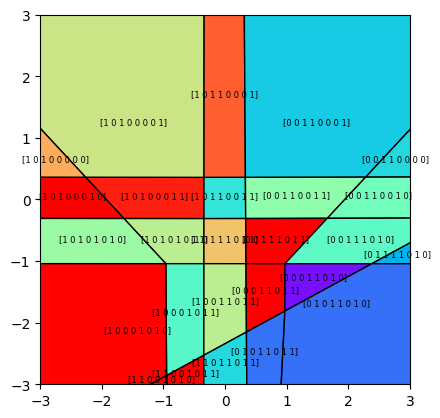

The number of polytopes within the boundaries is: 26


In [34]:
bound = 3


fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
patches = []
num_polygons = len(verticles_list_alg)
colors = [np.random.randint(1, 300) for i in range(num_polygons)]
cmap = matplotlib.colormaps['rainbow']

polytopes_within_boundaries = 0  # Counter for polytopes within boundaries

for i in range(num_polygons):
    vertices_i = verticles_list_alg[i]
    
    # Check if any vertex falls within the boundaries
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
    clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=vertices_i,
                          closed=True,
                          facecolor=cmap(colors[i]),
                          edgecolor='black',
                          label=np.transpose(bit_string_list_from_alg[i])[0],
                         )
        ax.add_patch(polygon)
        
        center_x, center_y = calculate_center_of_mass(clipped_vertices)
#         min_x = min(coord[0] for coord in clipped_vertices)
#         max_x = max(coord[0] for coord in clipped_vertices)
#         min_x = max(min_x, -bound)
#         max_x = min(max_x, bound)
#         center_x = 0.5 * (max_x - min_x) + min_x
#         min_y = min(coord[1] for coord in clipped_vertices)
#         max_y = max(coord[1] for coord in clipped_vertices)
#         min_y = max(min_y, -bound)
#         max_y = min(max_y, bound)
#         center_y = 0.5 * (max_y - min_y) + min_y

        ax.annotate(text=polygon.get_label(), xy=(center_x, center_y), ha='center', fontsize=6)
        patches.append(polygon)
        
        polytopes_within_boundaries += 1
#         print(vertices_i,bit_string_list_from_alg[i],min_x,min_y,center_x,center_y )
        
        
        

ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
np.random.seed(10)
colors = [np.random.randint(1, 1000) for i in range(len(patches))]
plt.show()

print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")


## 3d

In [35]:
model_8_nodes_2 = NeuralNet(input_size=3, num_classes=1, hidden_sizes=[4, 4])
model_8_nodes_2.load_state_dict(torch.load("example_models/demo_8_nodes_2.pth"))
model_8_nodes_2.eval()

NeuralNet(
  (l1): Linear(in_features=3, out_features=4, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [36]:
n = 50
x_1 = np.linspace(-1, 1, n, dtype="float32")
x_2 = np.linspace(-1, 1, n, dtype="float32")
x_3 = np.linspace(-1, 1, n, dtype="float32")

x_1, x_2, x_3 = np.meshgrid(x_1, x_2, x_3)
x_1 = np.reshape(x_1, (n**3,1))
x_2 = np.reshape(x_2, (n**3,1))
x_3 = np.reshape(x_3, (n**3,1))

y_train = np.asarray([(i**2)+2*((j-1)**2)+3*(k**2)-1 for i, j, k in zip(x_1, x_2, x_3)])
x_train = np.concatenate((x_1,x_2, x_3), axis = 1)

print(y_train.shape, x_train.shape)

# x_train_tp = np.transpose(x_train)

random.seed(8)
random_number = random.randint(0, x_train.shape[0]-1)

random_sample = np.transpose(x_train[random_number,:]).reshape(-1,1)
random_sample.shape

(125000, 1) (125000, 3)


(3, 1)

In [37]:
A_random_sample, c_random_sample = get_inequalities(model_8_nodes_2,random_sample,return_bit_vec_list=False, input_dimension=3 )
        
indexes_for_active_bits_random_sample, stats = active_bits_index_2 (A_random_sample[0],c_random_sample[0].reshape(-1) )

random_sample_bit_vector_list = bit_vector_from_relus(model_8_nodes_2, random_sample.reshape(-1,1), get_unique_bit_vectors_only=True)
random_sample_bit_vector=np.vstack(random_sample_bit_vector_list[0])

polytope_list, active_bit_count_list  = get_polytope_list(random_sample_bit_vector, indexes_for_active_bits_random_sample, input_dimension=3, model=model_8_nodes_2)

bit_string_list_from_alg = polytope_list

def divide_column_vector(column_vector):
    return np.array_split(column_vector, 2)

list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]

A_alg, c_alg = get_inequalities(model_8_nodes_2,list_of_lists_of_column_vectors_alg, is_input_sample=False,return_bit_vec_list=False, input_dimension=3 )
len(A_alg)

68

In [38]:
bound = 92

vertices_list = []
for A, c in zip (A_alg, c_alg):
    A = np.concatenate((A, np.array([[-1,0, 0], [0, -1, 0], [0,0, -1], [1, 0, 0], [0, 1, 0], [0, 0, 1]])))
    A = (-A).tolist()
    c = (-c_alg[0]).reshape(1,-1).tolist()[0]
    c = c + [-1,-1,-1,-1,-1,-1]
    vertices = lineqs3D(A, c, color='red', show=False, bounds = [[-bound, -bound, -bound], [bound, bound, bound]])
    vertices_list.append(vertices)
len(vertices_list)

68

<IPython.core.display.Javascript object>


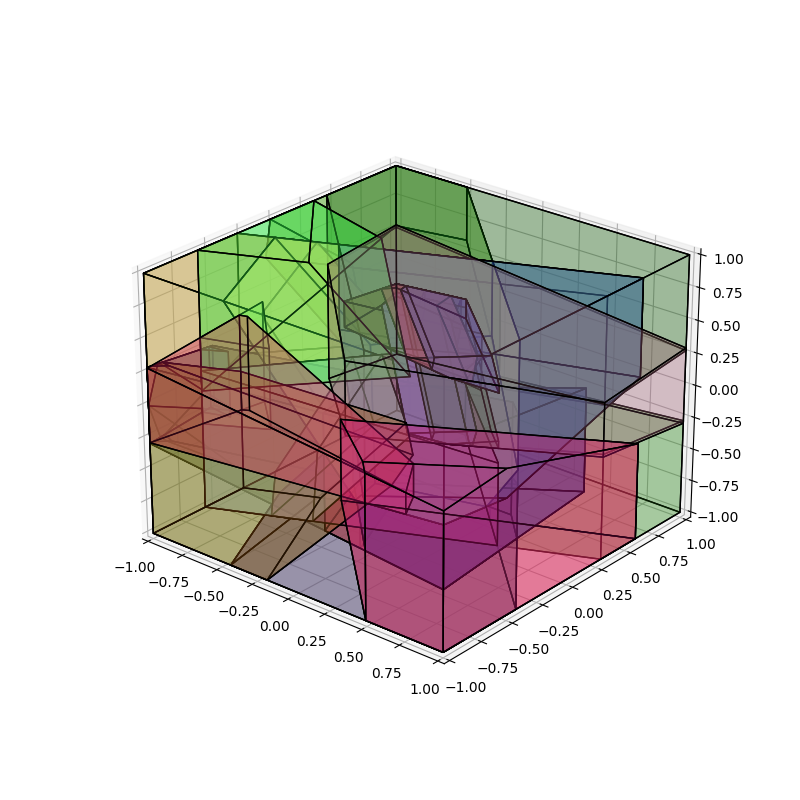

In [39]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Original plot
bound = 1
bounds = [[-bound, -bound, -bound], [bound, bound, bound]]
size = (8,8)
fig = plt.figure(figsize=size)
ax = fig.add_subplot(111, projection='3d')

polygons = []

# Generate example data for vertices_list_alg (replace with your actual data)
vertices_list_alg = vertices_list

num_polygons = len(vertices_list_alg)

# Generate random colors for each polygon
colors = np.random.rand(num_polygons, 3)

for i in range(num_polygons):
    polygon = Poly3DCollection(vertices_list_alg[i])
    polygon.set_edgecolor('k')  # Set edge color
    polygon.set_facecolor(colors[i])  # Set face color
    polygon.set_alpha(0.2)  # Set transparency
    polygons.append(polygon)
    ax.add_collection3d(polygon)

# Set plot limits
ax.set_xlim((bounds[0][0], bounds[1][0]))
ax.set_ylim((bounds[0][1], bounds[1][1]))
ax.set_zlim((bounds[0][2], bounds[1][2]))

# ax.set_xlabel('x_1')
# ax.set_ylabel('x_2')
# ax.set_zlabel('x_3')

# Change the point of view by setting the elevation and azimuth angles
ax.view_init(elev=25, azim=310)  # Adjust the angles as desired

plt.show()
